In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from matplotlib.patches import Rectangle
import cv2

/tmp/ipykernel_88080/2090175069.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
rois = sorted(list(pathlib.Path('../datasets/INbreast/my_rois').glob('*.tsv')))
print("number of rois:", len(list(rois)))

number of rois: 160


In [3]:
inbreast_images = list(pathlib.Path('/home/alalbiol/Data/mamo/INbreast/AllDICOMs').glob('*.dcm'))

print("number of images:", len(inbreast_images))


number of images: 410


In [4]:
def read_inbreast_anot(filename):
    a=pd.read_csv(str(filename),sep='\t')
    annots=[]
    for i in range(len(a)):
        #is it benign or malignant? otherwise skip
        if a.desc[i][0] == 'b':
            patho='BENIGN'
        elif a.desc[i][0] == 'm':
            patho='MALIGNANT'
        else:
            continue
            
        #make xy from bounding box
        xmin=a.x0[i]
        xmax=a.x1[i]
        ymin=a.y0[i]
        ymax=a.y1[i]
        
        #load imshape
        annots.append([filename.stem, patho, xmin, ymin, xmax, ymax])
    return annots


def load_imbreast_image(filename):
 
    """Load an image."""
    im = pydicom.dcmread(str(filename)).pixel_array
    
    #resize to max S
    

    #there is no information how to transform the pixels
    # it looks like this range is good
    im=np.clip(im,1000,2500)-1000
    #rescale
    im=(255.*im/im.max()).astype(np.uint8)
    
    return im  

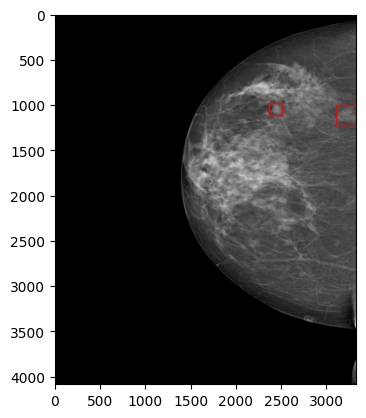

In [5]:
def show_annotation(labels_file):
    annotations = read_inbreast_anot(labels_file)
    
    image_file = [i for i in inbreast_images if labels_file.stem in i.stem][0]
   
    im = load_imbreast_image(image_file)
    fig, ax = plt.subplots(1)
    ax.imshow(im, cmap='gray')
    for a in annotations:
        rect = Rectangle((a[2], a[3]), a[4]-a[2], a[5]-a[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()
    
    
    
show_annotation(rois[0])

# Clase INbreast

In [6]:

import sys
sys.path.append('../datasets')


from inbreast import INbreast

In [7]:
dataset_folder = pathlib.Path("/home/alalbiol/Data/mamo/INbreast")
annotatiions_folder = pathlib.Path("../datasets/INbreast/my_rois")
inbreast = INbreast(dataset_folder, annotatiions_folder)
    
inbreast.print_num_abnormalities()

Number of images:  410
Number of annotations:  160
  AnnotatedImage: 20586908 with 2 abnormalities
  AnnotatedImage: 20586934 with 1 abnormalities
  AnnotatedImage: 20586960 with 2 abnormalities
  AnnotatedImage: 20586986 with 1 abnormalities
  AnnotatedImage: 20587054 with 6 abnormalities
  AnnotatedImage: 20587080 with 3 abnormalities
  AnnotatedImage: 20587148 with 0 abnormalities
  AnnotatedImage: 20587174 with 2 abnormalities
  AnnotatedImage: 20587200 with 0 abnormalities
  AnnotatedImage: 20587226 with 2 abnormalities
  AnnotatedImage: 20587294 with 0 abnormalities
  AnnotatedImage: 20587320 with 1 abnormalities
  AnnotatedImage: 20587346 with 0 abnormalities
  AnnotatedImage: 20587372 with 2 abnormalities
  AnnotatedImage: 20587466 with 0 abnormalities
  AnnotatedImage: 20587492 with 0 abnormalities
  AnnotatedImage: 20587518 with 0 abnormalities
  AnnotatedImage: 20587544 with 0 abnormalities
  AnnotatedImage: 20587612 with 1 abnormalities
  AnnotatedImage: 20587638 with 0 abn

In [8]:
images = inbreast.all_images

for i in images:
    if len(inbreast.all_annotated_cases[i]) > 0:
        print(i, len(inbreast.all_annotated_cases[i]))
        image = i
        break


/home/alalbiol/Data/mamo/INbreast/AllDICOMs/20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm 2


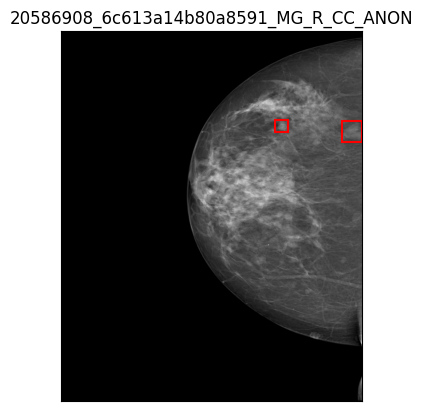

In [9]:
inbreast.show_case(image)

In [10]:
def read_yolo_anot(filename):
    anots = []
    with open(filename, 'r') as file:
        for lines in file:
            label, xcenter, ycenter, width, height = lines.split()
            anots.append({'label': label, 
                          'xcenter': float(xcenter), 
                          'ycenter': float(ycenter), 
                          'width': float(width), 
                          'height': float(height)})
    return anots
            



/tmp/inbreast_yolo/validation/images/20586908_6c613a14b80a8591_MG_R_CC_ANON.png
/tmp/inbreast_yolo/validation/labels/20586908_6c613a14b80a8591_MG_R_CC_ANON.txt
image shape: (2112, 1696, 3)


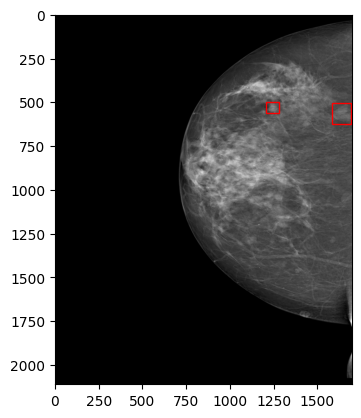

In [16]:
yolo_images = list(pathlib.Path('/tmp/inbreast_yolo/validation/images').glob('*.png'))
yolo_image = [i for i in yolo_images if i.stem == image.stem][0]
yolo_label = pathlib.Path(str(yolo_image).replace('images', 'labels').replace('png', 'txt'))
print(yolo_image)
print(yolo_label)

img = cv2.imread(str(yolo_image))
read_yolo_anot(yolo_label)

print("image shape:", img.shape)
plt.imshow(img)
for a in read_yolo_anot(yolo_label):
    x = int(a['xcenter']*img.shape[1])
    y = int(a['ycenter']*img.shape[0])
    w = int(a['width']*img.shape[1])
    h = int(a['height']*img.shape[0])
    rect = Rectangle((x-w/2, y-h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

In [12]:
image.stem

'20586908_6c613a14b80a8591_MG_R_CC_ANON'

In [13]:
yolo_images


NameError: name 'yolo_images' is not defined